# Classifying hand-labeled data with RICNN

## Imports and data setup

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imports.GDL_layers as GDL_layers

In [2]:
patch_ds = xr.load_dataset("/glade/scratch/lverhoef/HWT_hand_labled_data/patches.nc")
labels = pd.read_csv("/glade/scratch/lverhoef/HWT_hand_labled_data/labels.csv")
meta_ds = pd.read_csv("/glade/scratch/lverhoef/HWT_hand_labled_data/hs_data.csv")

In [3]:
patch_ds

<xarray.Dataset>
Dimensions:        (p: 2627, row: 144, col: 144)
Coordinates:
  * p              (p) int64 28 35 81 82 139 140 192 ... 80 81 83 122 123 124
  * row            (row) int32 0 1 2 3 4 5 6 7 ... 137 138 139 140 141 142 143
  * col            (col) int32 0 1 2 3 4 5 6 7 ... 137 138 139 140 141 142 143
Data variables:
    REFL_COM_curr  (p, row, col) float32 0.0 0.0 0.0 0.0 ... 28.78 37.25 41.45

In [4]:
labels

,Unnamed: 0,index,id,imgstring,conf1,conf2,conf3,conf4,conf5,label1,label2,label3,label4,label5,label
0,0,356805,d01_REFL_COM_20130129-0000_14_16_017_02,5,4,5,4,5,Q2,Q2,Q2,Q2,Q2,NaN,Q
1,1,356806,d01_REFL_COM_20130129-0000_15_16_022_01,3,3,4,5,3,D2,D2,D2,D2,D2,NaN,D
2,2,356830,d01_REFL_COM_20130129-0000_21_22_060_00,4,5,4,3,5,D1,D2,D1,D1,D1,NaN,D
3,3,356831,d01_REFL_COM_20130129-0000_21_22_060_01,4,5,5,5,5,D2,D1,D2,D1,D1,NaN,D
4,4,356855,d01_REFL_COM_20130129-0000_26_27_102_01,3,2,4,2,5,Q2,S2,Q2,S2,S2,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2622,2622,368734,d01_REFL_COM_20131221-0000_25_25_070_00,2,-1,-1,-1,-1,Q2,-1,-1,-1,-1,NaN,Q
2623,2623,368735,d01_REFL_COM_20131221-0000_25_26_072_00,5,-1,-1,-1,-1,Q2,-1,-1,-1,-1,NaN,Q
2624,2624,368758,d01_REFL_COM_20131221-0000_33_33_101_00,4,-1,-1,-1,-1,D1,-1,-1,-1,-1,NaN,D
2625,2625,368759,d01_REFL_COM_20131221-0000_33_33_102_00,3,-1,-1,-1,-1,Q2,-1,-1,-1,-1,NaN,Q


In [3]:
r_max = patch_ds.REFL_COM_curr.max()
r_min = patch_ds.REFL_COM_curr.min()

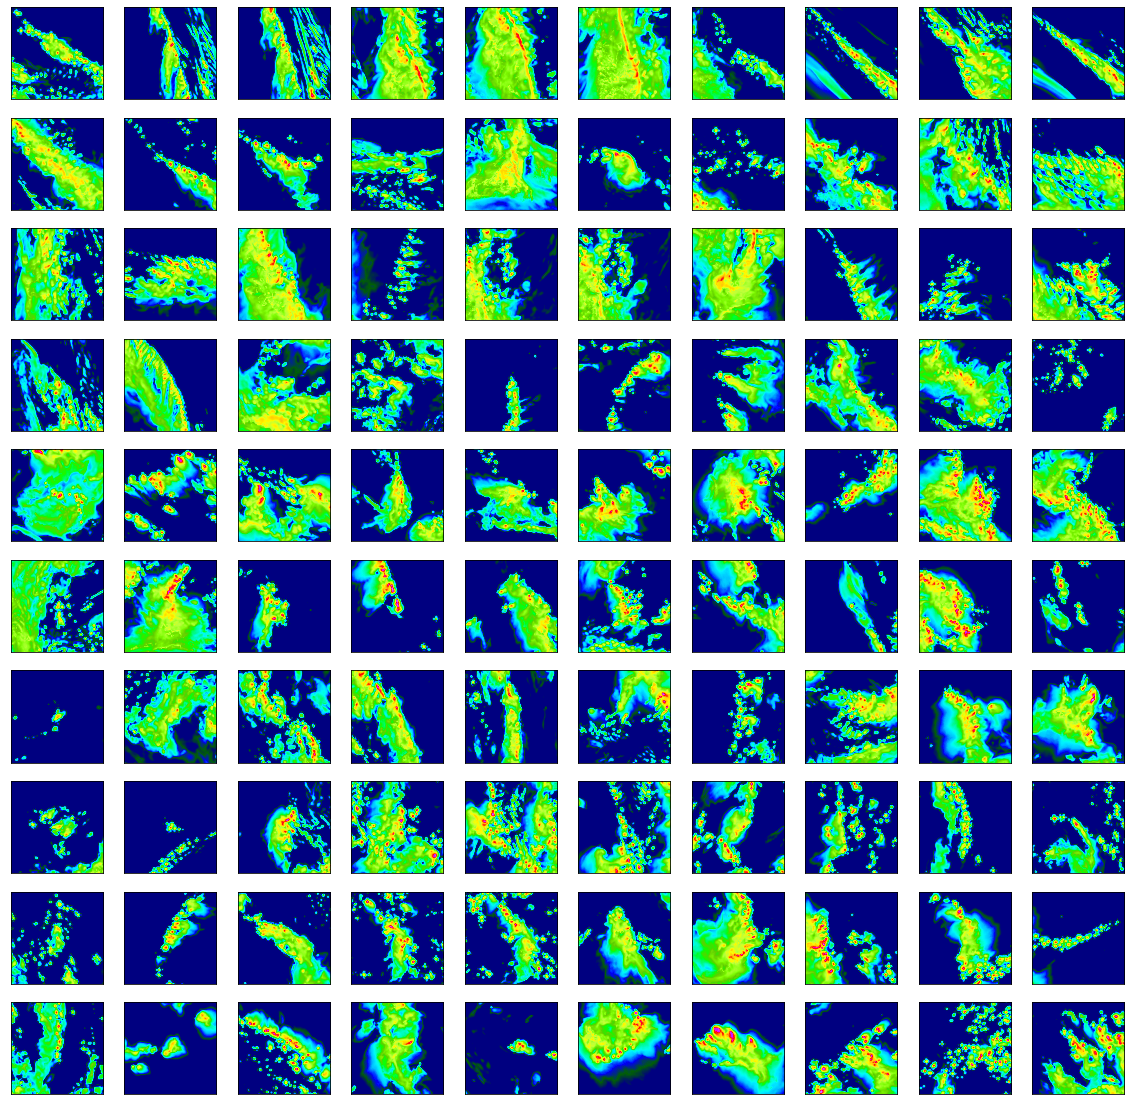

In [11]:
F, axes = plt.subplots(10, 10, figsize=(20, 20))
F.set_facecolor('white')
ims = patch_ds.REFL_COM_curr[list(labels.label == 'Q')]
for img_ind, ax in enumerate(axes.reshape(-1)):
    ax.imshow(ims[img_ind], cmap='gist_ncar', clim=(r_min, r_max))
    ax.set_xticks([])
    ax.set_yticks([])

[]

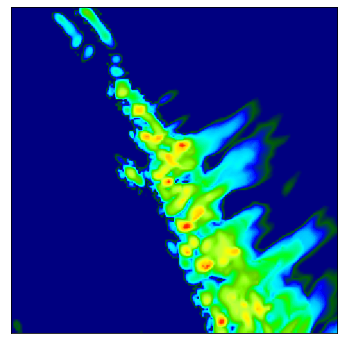

In [12]:
F, ax = plt.subplots(1, 1, figsize=(6, 6))
F.set_facecolor('white')
ax.imshow(ims[27], cmap='gist_ncar', clim=(r_min, r_max))
ax.set_xticks([])
ax.set_yticks([])

In [5]:
np.unique(labels.label)

array(['D', 'Q', 'S'], dtype=object)

In [6]:
meta_ds

,Step_ID,level_0,index,Track_ID,Ensemble_Name,Ensemble_Member,Run_Date,Valid_Date,Forecast_Hour,Valid_Hour_UTC,...,eccentricity,major_axis_length,minor_axis_length,orientation,Matched,Max_Hail_Size,Num_Matches,Shape,Location,Scale
0,d01_REFL_COM_20130129-0000_14_16_017_02,64051,27,d01_REFL_COM_20130129-0000_14_16_017,NCARSTORM,d01,2013-01-29 00:00:00,2013-01-29 16:00:00,16,16,...,0.98509,160.41632,27.59601,0.54045,0,0,0,0,0,0
1,d01_REFL_COM_20130129-0000_15_16_022_01,64058,34,d01_REFL_COM_20130129-0000_15_16_022,NCARSTORM,d01,2013-01-29 00:00:00,2013-01-29 16:00:00,16,16,...,0.84895,24.53140,12.96406,0.80756,0,0,0,0,0,0
2,d01_REFL_COM_20130129-0000_21_22_060_00,64104,80,d01_REFL_COM_20130129-0000_21_22_060,NCARSTORM,d01,2013-01-29 00:00:00,2013-01-29 21:00:00,21,21,...,0.80609,11.74471,6.95049,-1.06654,0,0,0,0,0,0
3,d01_REFL_COM_20130129-0000_21_22_060_01,64105,81,d01_REFL_COM_20130129-0000_21_22_060,NCARSTORM,d01,2013-01-29 00:00:00,2013-01-29 22:00:00,22,22,...,0.78239,11.54416,7.18959,0.50015,0,0,0,0,0,0
4,d01_REFL_COM_20130129-0000_26_27_102_01,64162,138,d01_REFL_COM_20130129-0000_26_27_102,NCARSTORM,d01,2013-01-29 00:00:00,2013-01-30 03:00:00,27,3,...,0.97903,36.37570,7.41074,0.40317,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2622,d01_REFL_COM_20131221-0000_25_25_070_00,103107,80,d01_REFL_COM_20131221-0000_25_25_070,NCARSTORM,d01,2013-12-21 00:00:00,2013-12-22 01:00:00,25,1,...,0.97671,42.26705,9.06883,0.40279,0,0,0,0,0,0
2623,d01_REFL_COM_20131221-0000_25_26_072_00,103109,82,d01_REFL_COM_20131221-0000_25_26_072,NCARSTORM,d01,2013-12-21 00:00:00,2013-12-22 01:00:00,25,1,...,0.95970,194.33514,54.61147,0.76621,0,0,0,0,0,0
2624,d01_REFL_COM_20131221-0000_33_33_101_00,103148,121,d01_REFL_COM_20131221-0000_33_33_101,NCARSTORM,d01,2013-12-21 00:00:00,2013-12-22 09:00:00,33,9,...,0.84974,9.66413,5.09487,0.12919,0,0,0,0,0,0
2625,d01_REFL_COM_20131221-0000_33_33_102_00,103149,122,d01_REFL_COM_20131221-0000_33_33_102,NCARSTORM,d01,2013-12-21 00:00:00,2013-12-22 09:00:00,33,9,...,0.96739,52.38941,13.27037,0.34986,0,0,0,0,0,0


In [7]:
def coder(lab):
    if lab == "D":
        return 0
    elif lab == "Q":
        return 1
    else:
        return 2


coded_labels = xr.DataArray([coder(lab) for lab in labels.label])

In [8]:
uniq, counts = np.unique(coded_labels, return_counts=True)
print(counts)

[1661  407  559]


In [9]:
train_split = int(patch_ds["p"].shape[0] * 0.8)
val_split = int(patch_ds["p"].shape[0] * 0.9)
input_train = patch_ds["REFL_COM_curr"][:train_split, :, :].expand_dims("channel", axis=-1)
input_val = patch_ds["REFL_COM_curr"][train_split:val_split, :, :].expand_dims("channel", axis=-1)
input_test = patch_ds["REFL_COM_curr"][val_split:, :, :].expand_dims("channel", axis=-1)
labels_train = coded_labels[:train_split]
labels_val = coded_labels[train_split:val_split]
labels_test = coded_labels[val_split:]

In [10]:
print(input_train.shape)
print(input_val.shape)
print(input_test.shape)
print(labels_train.shape)
print(labels_val.shape)
print(labels_test.shape)

(2101, 144, 144, 1)
(263, 144, 144, 1)
(263, 144, 144, 1)
(2101,)
(263,)
(263,)


In [11]:
# Normalize the input data
scale_stats = pd.DataFrame(index=[0], columns=["mean", "sd"])
scale_stats.loc[0, "mean"] = input_train.mean()
scale_stats.loc[0, "sd"] = input_train.std()
input_train_norm = (input_train - scale_stats.loc[0, "mean"]) / scale_stats.loc[0, "sd"]
input_val_norm = (input_val - scale_stats.loc[0, "mean"]) / scale_stats.loc[0, "sd"]
input_test_norm = (input_test - scale_stats.loc[0, "mean"]) / scale_stats.loc[0, "sd"]

## Define and train models

In [76]:
ricnn_model = models.Sequential()
ricnn_model.add(GDL_layers.RotEquivConv2D(16, (5, 5), rot_axis=False, input_shape=(144, 144, 1), kernel_regularizer="L2"))
ricnn_model.add(GDL_layers.RotEquivPool2D((2, 2), pool_method=tf.keras.layers.AvgPool2D))
ricnn_model.add(GDL_layers.RotEquivConv2D(32, (5, 5), kernel_regularizer="L2"))
ricnn_model.add(GDL_layers.RotEquivPool2D((2, 2), pool_method=tf.keras.layers.AvgPool2D))
ricnn_model.add(GDL_layers.RotEquivConv2D(64, (5, 5), kernel_regularizer="L2"))
ricnn_model.add(GDL_layers.RotEquivPool2D((2, 2), pool_method=tf.keras.layers.AvgPool2D))
ricnn_model.add(GDL_layers.RotEquivConv2D(128, (5, 5), kernel_regularizer="L2"))
ricnn_model.add(GDL_layers.RotInvPool())
ricnn_model.add(layers.Flatten())
ricnn_model.add(layers.Dense(32, activation='relu', kernel_regularizer="L2"))
ricnn_model.add(layers.Dropout(rate=0.2))
ricnn_model.add(layers.Dense(3))

In [77]:
ricnn_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rot_equiv_conv2d_32 (RotEqu  (None, 140, 140, 4, 16)  416       
 ivConv2D)                                                       
                                                                 
 rot_equiv_pool2d_24 (RotEqu  (None, 70, 70, 4, 16)    0         
 ivPool2D)                                                       
                                                                 
 rot_equiv_conv2d_33 (RotEqu  (None, 66, 66, 4, 32)    12832     
 ivConv2D)                                                       
                                                                 
 rot_equiv_pool2d_25 (RotEqu  (None, 33, 33, 4, 32)    0         
 ivPool2D)                                                       
                                                                 
 rot_equiv_conv2d_34 (RotEqu  (None, 29, 29, 4, 64)  

In [78]:
ricnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [87]:
ricnn_history = ricnn_model.fit(
    x=input_train_norm,
    y=labels_train,
    batch_size=32,
    epochs=100,
    validation_data=(input_val_norm, labels_val)
)

Epoch 1/100
66/66 [==============================] - 3s 51ms/step - loss: 1.2766 - accuracy: 0.8672 - val_loss: 1.9172 - val_accuracy: 0.6084
Epoch 2/100
66/66 [==============================] - 3s 50ms/step - loss: 1.2943 - accuracy: 0.8629 - val_loss: 1.9000 - val_accuracy: 0.6616
Epoch 3/100
66/66 [==============================] - 3s 50ms/step - loss: 1.2824 - accuracy: 0.8582 - val_loss: 1.9362 - val_accuracy: 0.5932
Epoch 4/100
66/66 [==============================] - 3s 50ms/step - loss: 1.2549 - accuracy: 0.8801 - val_loss: 1.9372 - val_accuracy: 0.6350
Epoch 5/100
66/66 [==============================] - 3s 53ms/step - loss: 1.2565 - accuracy: 0.8705 - val_loss: 1.8879 - val_accuracy: 0.6388
Epoch 6/100
66/66 [==============================] - 3s 53ms/step - loss: 1.2399 - accuracy: 0.8762 - val_loss: 1.9032 - val_accuracy: 0.6236
Epoch 7/100
66/66 [==============================] - 3s 50ms/step - loss: 1.2384 - accuracy: 0.8901 - val_loss: 1.9036 - val_accuracy: 0.6046
Epoch 

In [88]:
preds = ricnn_model.predict(input_test_norm)
preds

9/9 [==============================] - 0s 19ms/step


array([[-1.51826525e+00, -3.51556349e+00,  2.74124980e+00],
       [-1.18972160e-01,  2.91214705e-01, -1.94204724e+00],
       [-2.45128885e-01, -3.78177524e+00,  2.35472488e+00],
       [ 1.06374884e+00, -8.54007840e-01, -1.74015892e+00],
       [ 1.31147552e+00, -3.05443287e+00,  1.82259893e+00],
       [-1.34327829e+00,  2.24811912e+00, -1.17173111e+00],
       [ 3.24014807e+00, -4.07766390e+00, -3.56242371e+00],
       [ 7.56558895e+00, -7.26157141e+00, -2.72041583e+00],
       [ 3.31635332e+00, -4.34144354e+00,  8.57020080e-01],
       [ 9.26204860e-01, -1.35499287e+00, -6.48456001e+00],
       [ 3.34923029e+00, -1.21654756e-02, -2.53803182e+00],
       [ 1.43850863e+00, -4.82316065e+00,  2.25801992e+00],
       [-1.01376653e+00, -5.25471783e+00,  4.49844360e+00],
       [ 2.57939911e+00, -5.56684828e+00,  1.06131232e+00],
       [-2.24176764e-01,  8.21477175e-01, -5.35076141e+00],
       [ 1.43620038e+00,  3.55154371e+00, -2.07119966e+00],
       [ 4.92025709e+00, -3.55295372e+00

In [89]:
np.argmax(preds, axis=1)

array([2, 1, 2, 0, 2, 1, 0, 0, 0, 0, 0, 2, 2, 0, 1, 1, 0, 2, 0, 2, 2, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 1, 2, 1, 0, 0, 0, 0,
       2, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0,
       2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0,
       0, 0, 0, 2, 0, 0, 1, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 2, 2, 1, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

In [91]:
labels_test

<xarray.DataArray (dim_0: 263)>
array([0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 2, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 1, 0, 2, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 2, 0, 1, 0, 0, 0, 2, 0, 0, 0, 2, 1, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 2, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1])
Dimensions without coordinates: dim_0

In [47]:
np.unique(labels_val, return_counts=True)

(array([0, 1, 2]), array([183,  33,  47]))

In [90]:
np.unique(np.argmax(preds, axis=1), return_counts=True)

(array([0, 1, 2]), array([192,  24,  47]))

In [93]:
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(16, (5, 5), input_shape=(144, 144, 1), kernel_regularizer="L2"))
cnn_model.add(layers.AveragePooling2D((2, 2)))
cnn_model.add(layers.Conv2D(32, (5, 5), kernel_regularizer="L2"))
cnn_model.add(layers.AveragePooling2D((2, 2)))
cnn_model.add(layers.Conv2D(64, (5, 5), kernel_regularizer="L2"))
cnn_model.add(layers.AveragePooling2D((2, 2)))
cnn_model.add(layers.Conv2D(128, (5, 5), kernel_regularizer="L2"))
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(32, activation='relu'))
cnn_model.add(layers.Dropout(rate=0.2))
cnn_model.add(layers.Dense(3))

In [94]:
cnn_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 140, 140, 16)      416       
                                                                 
 average_pooling2d_33 (Avera  (None, 70, 70, 16)       0         
 gePooling2D)                                                    
                                                                 
 conv2d_17 (Conv2D)          (None, 66, 66, 32)        12832     
                                                                 
 average_pooling2d_34 (Avera  (None, 33, 33, 32)       0         
 gePooling2D)                                                    
                                                                 
 conv2d_18 (Conv2D)          (None, 29, 29, 64)        51264     
                                                                 
 average_pooling2d_35 (Avera  (None, 14, 14, 64)     

In [95]:
cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [100]:
cnn_history = cnn_model.fit(
    input_train_norm,
    labels_train,
    batch_size=32,
    epochs=220,
    validation_data=(input_val_norm, labels_val)
)

Epoch 1/220
66/66 [==============================] - 1s 15ms/step - loss: 1.0402 - accuracy: 0.9424 - val_loss: 2.9091 - val_accuracy: 0.5856
Epoch 2/220
66/66 [==============================] - 1s 14ms/step - loss: 1.0367 - accuracy: 0.9376 - val_loss: 2.9139 - val_accuracy: 0.5817
Epoch 3/220
66/66 [==============================] - 1s 14ms/step - loss: 1.0403 - accuracy: 0.9400 - val_loss: 2.8968 - val_accuracy: 0.5741
Epoch 4/220
66/66 [==============================] - 1s 14ms/step - loss: 1.0203 - accuracy: 0.9434 - val_loss: 2.9221 - val_accuracy: 0.5817
Epoch 5/220
66/66 [==============================] - 1s 14ms/step - loss: 1.0262 - accuracy: 0.9391 - val_loss: 2.9080 - val_accuracy: 0.5779
Epoch 6/220
66/66 [==============================] - 1s 14ms/step - loss: 1.0252 - accuracy: 0.9396 - val_loss: 2.9186 - val_accuracy: 0.5703
Epoch 7/220
66/66 [==============================] - 1s 14ms/step - loss: 1.0264 - accuracy: 0.9391 - val_loss: 2.8675 - val_accuracy: 0.5779
Epoch 

In [97]:
preds2 = cnn_model.predict(input_test_norm)
preds2

9/9 [==============================] - 0s 7ms/step


array([[ 3.30270886e-01,  1.78975165e-01, -3.97888470e+00],
       [ 1.31913018e+00,  1.17661512e+00, -3.66855669e+00],
       [ 5.48709965e+00,  3.72909331e+00, -4.45701647e+00],
       [ 6.54636574e+00, -1.46628964e+00, -2.14952588e+00],
       [-9.12447035e-01, -3.06615782e+00,  9.37505811e-02],
       [ 1.78896356e+00,  9.29343641e-01,  1.30120233e-01],
       [ 5.78450561e-01, -2.04257560e+00,  1.88825631e+00],
       [ 3.59089303e+00,  7.32008874e-01, -4.16990757e+00],
       [ 1.35377920e+00, -2.86462140e+00, -6.43345952e-01],
       [ 3.05591702e+00, -1.53639019e+00, -5.01467705e+00],
       [-8.00353336e+00, -5.02317333e+00, -1.42633080e+00],
       [-1.88885629e-01, -2.68102193e+00, -3.07201743e+00],
       [ 9.99962330e+00,  6.01042652e+00,  1.72425354e+00],
       [-3.01740551e+00, -3.01943588e+00, -5.09859371e+00],
       [ 7.62910318e+00,  3.09721255e+00, -2.82053447e+00],
       [-2.07966730e-01, -7.56334126e-01, -6.86657667e+00],
       [ 1.27368145e+01,  4.84811592e+00

In [98]:
np.argmax(preds2, axis=1)

array([0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 2, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 2, 2, 0, 2, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0,
       0, 0, 2, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 2, 1,
       0, 0, 0, 0, 1, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 2, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1])

In [99]:
np.unique(np.argmax(preds2, axis=1), return_counts=True)

(array([0, 1, 2]), array([209,  27,  27]))